In [19]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

import spl.encoders as spe
import spl.functional as spf
from spl.generators import SSPGenerator
import spl.plotting as spp

In [20]:
# -----------------------------
# Hyperparameter Configuration
# -----------------------------
axis_resolution: int = 128
axis_limit: int = 5
length_scale: int = 5
random_seed: int = 0
vsa_dimensions: int = 512

device: str = torch.device("cpu")

In [21]:
# -----------------------------------
# Initialize Libraries and Utilities
# -----------------------------------
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

ssp_gen = SSPGenerator(
    dimensionality=vsa_dimensions,
    device=device
)

In [22]:
# -------------------------
# Specify Object Locations
# -------------------------
label_vectors: dict = {
    "class": spf.make_good_unitary(vsa_dimensions, device),
    "x": spf.make_good_unitary(vsa_dimensions, device),
    "y": spf.make_good_unitary(vsa_dimensions, device)
}

objects: dict = {
    "fox": {
        "locations": torch.tensor([[3, -2]]),
        "symbol": spf.make_good_unitary(vsa_dimensions, device)
    }
}

axis_bounds = torch.tensor([-axis_limit, axis_limit, -axis_limit, axis_limit])

In [23]:
# -----------------------------------
# Initialize Spatial Data Structures
# -----------------------------------
x_axis = torch.linspace(-axis_limit, axis_limit, axis_resolution, device=device)
x_axis = x_axis.reshape((-1, 1))

y_axis = torch.linspace(-axis_limit, axis_limit, axis_resolution, device=device)
y_axis = y_axis.reshape((-1, 1))

axis_basis_vectors: torch.tensor = ssp_gen.generate(2)

xy_axis_matrix = torch.zeros((axis_resolution, axis_resolution, vsa_dimensions), device=device)
for i, x in enumerate(x_axis):
    for j, y in enumerate(y_axis):
        vs = [spf.power(axis_basis_vectors[0], x), spf.power(axis_basis_vectors[1], y)]
        xy_axis_matrix[i, j, :] = spf.bind(vs, device)

In [24]:
# --------------
# Create Memory
# --------------
memory = torch.zeros(vsa_dimensions)

for object_key in objects:
    symbol_vector: torch.tensor = objects[object_key]["symbol"]
    locations: torch.tensor = objects[object_key]["locations"]

    # encode each location is cartesian space to hyperdimensional space
    location_vectors = torch.zeros((locations.shape[0], vsa_dimensions))
    for i in range(locations.shape[0]):
        location_vectors[i, :] = spe.encode_cartesian(locations[i], axis_basis_vectors, device=device)

    # bind each location vector with the associated symbol
    for i in range(locations.shape[0]):
        vs = [location_vectors[i, :], symbol_vector]
        location_vectors[i, :] = spf.bind(vs, device)

    for i in range(locations.shape[0]):
        memory += location_vectors[i, :]

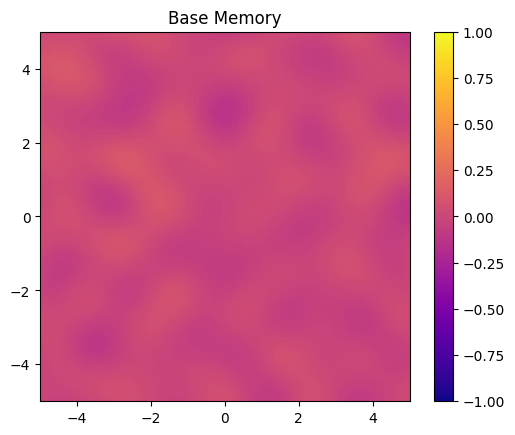

In [25]:
spp.plot_2d_heatmap_unqueried(
    query=memory,
    plane_matrix=xy_axis_matrix,
    title="Base Memory",
    axis_bounds=axis_bounds
)

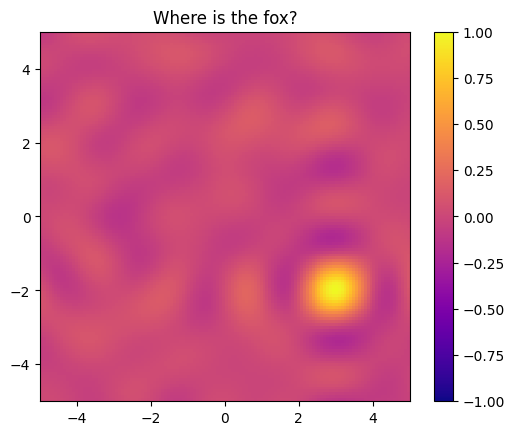

In [26]:
vs = [spf.invert(objects["fox"]["symbol"]), memory]
fox_decoded = spf.bind(vs, device)

spp.plot_2d_heatmap_unqueried(
    query=fox_decoded,
    plane_matrix=xy_axis_matrix,
    title="Where is the fox?",
    axis_bounds=axis_bounds
)